In [38]:
import jax
import os
import xarray as xr
import pandas as pd
import numpy as np
import jax.numpy as jnp
from flax.training.checkpoints import restore_checkpoint
from flax import linen as nn
from mlp import MLP
import unet
from tunax.space import Trajectory
from tunax import Grid

from typing import List, Tuple, TypeAlias
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]

In [2]:

# Load max_vals and min_vals
max_vals = np.load("data/max_vals.npy")  # Shape: (5,)
min_vals = np.load("data/min_vals.npy")  # Shape: (5,)

# Load permutation indices
train_indices = np.load("data/train_indices.npy")  # Permutation indices for training data
test_indices = np.load("data/test_indices.npy")  # Permutation indices for test data

Postprocessing

1. Load data and train_state
2. Apply MLP
3. De-normalize Data
4. Add to a tunax trajectory
5. Plot and Compare to Direct Model

In [3]:
def traj_from_ds(ds: xr.Dataset, grid: Grid, different_temperature=None) -> Trajectory:
    """
    Creates a Trajectory from an xarray.Dataset.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing the trajectory data. Must have variables `u`, `v`, `t`, `s`,
        and coordinates `time`, `zr`, `zw`.
    grid : Grid
        The Grid object used to define the geometry of the trajectory.

    Returns
    -------
    trajectory : Trajectory
        The reconstructed Trajectory object.
    """
    # Ensure the dataset contains all required variables and coordinates
    required_variables = ['u', 'v', 't', 's']
    required_coords = ['time', 'zr', 'zw']

    for var in required_variables:
        if var not in ds:
            raise ValueError(f"Dataset is missing required variable '{var}'.")
    for coord in required_coords:
        if coord not in ds.coords:
            raise ValueError(f"Dataset is missing required coordinate '{coord}'.")

    # Extract data from the dataset
    time = ds['time'].values
    u = ds['u'].values  # Shape: (nt, nz) i.e. (360, 50)
    v = ds['v'].values  # Shape: (nt, nz)
    t = ds['t'].values  # Shape: (nt, nz)
    s = ds['s'].values  # Shape: (nt, nz)
    
    if different_temperature is not None:
        t = different_temperature

    # Construct and return the Trajectory object
    return Trajectory(
        grid=grid,
        time=time,
        u=u,
        v=v,
        t=t,
        s=s,
    )

In [4]:
# Load application data
app_data = np.load("data/inf_combined_data.npy")
app_labels = np.load("data/inf_labels.npy")

# Convert to jax
app_data_unet = jnp.array(np.transpose(app_data, [0, 2, 1]))
app_data = jnp.array(app_data)
app_labels = jnp.array(app_labels)

In [14]:
n_sim = 100 # metadata to handle (.yaml?)
n_time = app_data.shape[0] // n_sim
grid = Grid.linear(50, 50)

In [6]:
data_dir = "data/"  # where simulations files are stored
file_names = [f"traj{i}.nc" for i in range(n_sim)]
file_paths = [os.path.join(data_dir, name) for name in file_names]

In [7]:
# sript to generalize for whichever beginning index

# create a function that takes in the beginning time index and returns the data and labels
def get_data_labels(app_data: jnp.array, n_sim: int, beginning_index: int):
    # add defaults for n_sim and beginning_index
    # get time dimension
    n_time = app_data.shape[0]//n_sim
    included_indices = np.arange(n_sim)*n_time + beginning_index
    data = app_data[beginning_index:beginning_index+360]
    labels = app_labels[beginning_index:beginning_index+360]
    return data, labels

In [39]:
# Load state dict
checkpoint_dir = os.path.abspath("checkpoints")
params = restore_checkpoint(checkpoint_dir, target=None)

# Initialize models
model = MLP(hidden_sizes=[64, 64])
unet_1D = unet.UNet1D(in_channels=5, out_channels=50)

checkpoint_dir_noise = os.path.abspath("checkpoints_noise")
params_noise = restore_checkpoint(checkpoint_dir_noise, target=None)

checkpoint_dir_reg = os.path.abspath("checkpoints_reg")
params_reg = restore_checkpoint(checkpoint_dir_reg, target=None)

checkpoint_dir_unet = os.path.abspath("checkpoints_unet")
params_unet = restore_checkpoint(checkpoint_dir_unet, target=None)

/home/durifa/anaconda3/envs/tunax_env/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [41]:
# Apply U-Net model
in_channels = 5
unet_model = unet.UNet1D_base(in_channels=in_channels, out_channels=1)
variables = unet_model.init(jax.random.PRNGKey(0), app_data_unet)
inf_predictions_unet = unet_model.apply(variables, app_data_unet)
print(inf_predictions_unet.shape)

(35900, 50, 1)


In [10]:
# Apply model
inf_predictions = model.apply(params, app_data)
inf_predictions_noise = model.apply(params_noise, app_data)
inf_predictions_reg = model.apply(params_reg, app_data)

In [11]:
def moving_average(x, w: int = 5):
    # x jnp one dimensional array
    x_avg = pd.DataFrame(x).rolling(w, center=True).mean().values
    # handle nans and replace them with the original values
    for i in range(w//2):
        x_avg[i] = x[i]
        x_avg[-i-1] = x[-i-1]
    x_avg = x_avg.reshape(-1)
    return np.array(x_avg)

In [12]:
def inference_to_traj(inf_predictions, file_names, n_time, grid, ma_window = 0):
    
    n_sim = len(file_names)
    # split back to individual trajectories/simulations
    inf_traj = [trajectory for trajectory in inf_predictions.reshape(n_sim, n_time, -1)]
    # sum up the predictions over time (delta T to T)
    inf_traj = [np.cumsum(inf_traj[i], axis=0) for i in range(n_sim)]
    
    if ma_window>0:
        # TO OPTIMIZE, very long (27s)
        # smooth predictions with moving average
        inf_traj_ma = inf_traj.copy()
        for i_sim in range(n_sim):
            for i_t in range(n_time):
                inf_traj_ma[i_sim] = inf_traj_ma[i_sim].at[i_t].set(moving_average(inf_traj_ma[i_sim][i_t], w=ma_window))
        inf_traj = inf_traj_ma.copy()
    
    # Initialize trajectories
    file_paths = [os.path.join("data/", name) for name in file_names]
    n_depth = len(inf_traj[0][0])
    init_full_traj = np.zeros((n_time+1, n_depth))
    original_traj = [None] * n_sim
    deep_traj = [None] * n_sim
    track_param = np.zeros((n_sim, 3))
    
    for i, file_path in enumerate(file_paths):
        
        # Load original trajectory
        data = xr.open_dataset(file_path)
        original_traj[i] = traj_from_ds(data, grid)
        
        # Track parameters
        track_param[i] = data.attrs.get('strat_t', 0.0), data.attrs.get('u', 0.0), data.attrs.get('c1', 0.0)
        
        # Create deep-learning Trajectory
        # Get initial temperature
        initial_temp = data["t"][0].values
        # Initialize first time step
        init_full_traj[0, :] = initial_temp
        
        # Add the trajectory computed with deep learning
        init_full_traj[1:, :] = inf_traj[i] + initial_temp
        inf_traj[i] = init_full_traj
        
        # Instantiate a Trajectory
        deep_traj[i] = traj_from_ds(data, grid, inf_traj[i])
    
    return deep_traj, original_traj
        
        

In [16]:
deep_traj_reg, original_traj = inference_to_traj(inf_predictions_reg, file_names, n_time, grid)

In [22]:
n_time

359

In [44]:
# Split back to individual simulations
inf_traj = [trajectory for trajectory in inf_predictions.reshape(n_sim, n_time, -1)]
inf_traj_noise = [trajectory for trajectory in inf_predictions_noise.reshape(n_sim, n_time, -1)]
inf_traj_reg = [trajectory for trajectory in inf_predictions_reg.reshape(n_sim, n_time, -1)]
inf_traj_unet = [trajectory for trajectory in inf_predictions_unet.reshape(n_sim, n_time, -1)]
# TO MODIFY LATER
#inf_traj_unet = [trajectory for trajectory in inf_predictions.reshape(n_sim, n_time, -1)]

# sum up the predictions over time (delta T to T)
inf_traj = [np.cumsum(inf_traj[i], axis=0) for i in range(n_sim)]
inf_traj_noise = [np.cumsum(inf_traj_noise[i], axis=0) for i in range(n_sim)]
inf_traj_reg = [np.cumsum(inf_traj_reg[i], axis=0) for i in range(n_sim)]
inf_traj_unet = [np.cumsum(inf_traj_unet[i], axis=0) for i in range(n_sim)]

In [45]:
# smooth predictions with moving average
inf_traj_ma = inf_traj.copy()
for i_sim in range(n_sim):
    for i_t in range(n_time):
        inf_traj_ma[i_sim] = inf_traj_ma[i_sim].at[i_t].set(moving_average(inf_traj_ma[i_sim][i_t], w=5))

In [46]:

# Create a trajectory from deep model results

# initialize a matrix with the right dimensions (prediction time+1)
n_depth = len(inf_traj[0][0])
init_full_traj = np.zeros((n_time+1, n_depth))
init_full_traj_noise = np.zeros((n_time+1, n_depth))
init_full_traj_reg = np.zeros((n_time+1, n_depth))
init_full_traj_ma = np.zeros((n_time+1, n_depth))
init_full_traj_unet = np.zeros((n_time+1, n_depth))

# Track parameters
track_param = np.zeros((n_sim, 3))

# Prepare Trajectories
original_traj = [None] * n_sim
deep_traj = [None] * n_sim
deep_traj_noise = [None] * n_sim
deep_traj_reg = [None] * n_sim
deep_traj_ma = [None] * n_sim
deep_traj_unet = [None] * n_sim


for i, file_path in enumerate(file_paths):
    
    # Load original trajectory
    data = xr.open_dataset(file_path)
    original_traj[i] = traj_from_ds(data, grid)
    
    # Track parameters
    track_param[i] = data.attrs.get('strat_t', 0.0), data.attrs.get('u', 0.0), data.attrs.get('c1', 0.0)
    
    # Create the deep-learning Trajectory
    # Get initial temperature
    initial_temp = data["t"][0].values
    # Initialize the first time step
    init_full_traj[0, :] = initial_temp
    init_full_traj_noise[0, :] = initial_temp
    init_full_traj_reg[0, :] = initial_temp
    init_full_traj_ma[0, :] = initial_temp
    init_full_traj_unet[0, :] = initial_temp
    
    # Add the trajectory computed with deep learning
    init_full_traj[1:, :] = inf_traj[i] + initial_temp
    init_full_traj_noise[1:, :] = inf_traj_noise[i] + initial_temp
    init_full_traj_reg[1:, :] = inf_traj_reg[i] + initial_temp
    init_full_traj_ma[1:, :] = inf_traj_ma[i] + initial_temp
    init_full_traj_unet[1:, :] = inf_traj_unet[i] + initial_temp
    inf_traj[i] = init_full_traj
    inf_traj_noise[i] = init_full_traj_noise
    inf_traj_reg[i] = init_full_traj_reg
    inf_traj_ma[i] = init_full_traj_ma
    inf_traj_unet[i] = init_full_traj_unet
    
    # Instantiate a Trajectory
    deep_traj[i] = traj_from_ds(data, grid, inf_traj[i])
    deep_traj_noise[i] = traj_from_ds(data, grid, inf_traj_noise[i])
    deep_traj_reg[i] = traj_from_ds(data, grid, inf_traj_reg[i])
    deep_traj_ma[i] = traj_from_ds(data, grid, inf_traj_ma[i])
    deep_traj_unet[i] = traj_from_ds(data, grid, inf_traj_unet[i])

/tmp/ipykernel_150183/3120178696.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_v.legend(framealpha=1.)


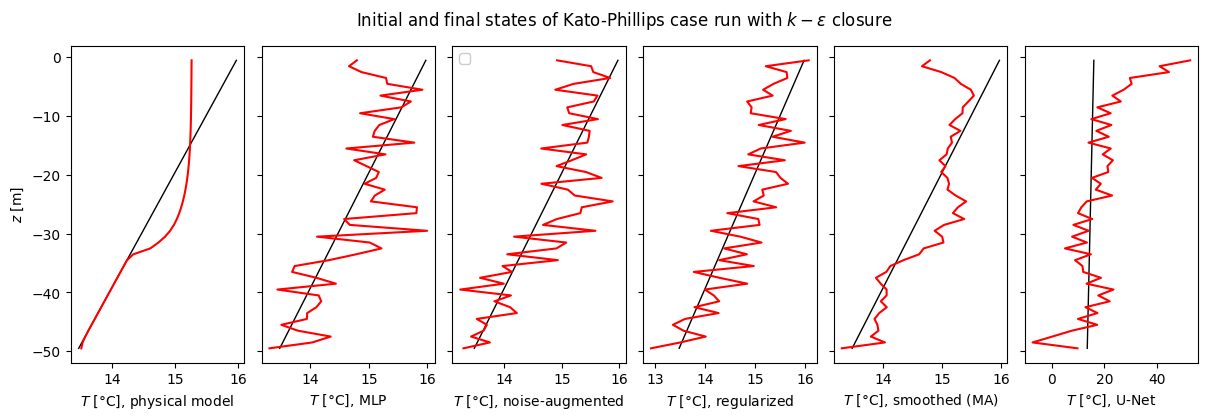

This trajectory is implied by the following parameters: 
strat_t = 0.143, u = 0.033, c1 = 8.05.
Regularization parameter: alpha = 0.01


In [47]:
# Plot and compare to actual trajectory

sim_index = -1
traj_obs = original_traj[sim_index]
traj_deep = deep_traj[sim_index]
traj_deep_noise = deep_traj_noise[sim_index]
traj_deep_reg = deep_traj_reg[sim_index]
traj_deep_ma = deep_traj_ma[sim_index]
traj_deep_unet = deep_traj_unet[sim_index]

zr = grid.zr

sp: subplot_1D_type = plt.subplots(1, 6, sharey=True, figsize=(12, 4))
fig, [ax_t, ax_u, ax_v, ax_w, ax_x, ax_y] = sp
fig.tight_layout(rect=[0, 0.0, 1, 0.94])
fig.subplots_adjust(wspace=0.1)

ax_t.plot(traj_obs.t[0, :], zr, 'k', linewidth=1)
ax_t.plot(traj_obs.t[-1, :], zr, 'r')
ax_u.plot(traj_deep.t[0, :], zr, 'k', linewidth=1)
ax_u.plot(traj_deep.t[-1, :], zr, 'r')
ax_v.plot(traj_deep_noise.t[0, :], zr, 'k', linewidth=1)
ax_v.plot(traj_deep_noise.t[-1, :], zr, 'r')
ax_w.plot(traj_deep_reg.t[0, :], zr, 'k', linewidth=1)
ax_w.plot(traj_deep_reg.t[-1, :], zr, 'r')
ax_x.plot(traj_deep_ma.t[0, :], zr, 'k', linewidth=1)
ax_x.plot(traj_deep_ma.t[-1, :], zr, 'r')
ax_y.plot(traj_deep_unet.t[0, :], zr, 'k', linewidth=1, label='initial state')
ax_y.plot(traj_deep_unet.t[-1, :], zr, 'r', label='final state')

ax_t.set_xlabel ('$T$ [°C], physical model')
ax_u.set_xlabel ('$T$ [°C], MLP')
ax_v.set_xlabel('$T$ [°C], noise-augmented')
ax_w.set_xlabel('$T$ [°C], regularized')
ax_x.set_xlabel('$T$ [°C], smoothed (MA)')
ax_y.set_xlabel('$T$ [°C], U-Net')
ax_t.set_ylabel(r'$z$ [m]')
fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
ax_v.legend(framealpha=1.)

plt.show()

print(f'This trajectory is implied by the following parameters: ')
print(f'strat_t = {round(track_param[sim_index, 0], 3)}, u = {round(track_param[sim_index, 1], 3)}, c1 = {round(track_param[sim_index, 2], 3)}.')
print(f'Regularization parameter: alpha = 0.01')

This trajectory is implied by the following parameters: 
strat_t = 0.143, u = 0.033, c1 = 8.05.


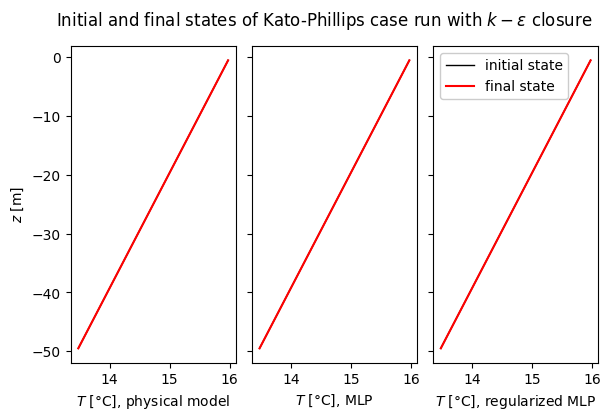

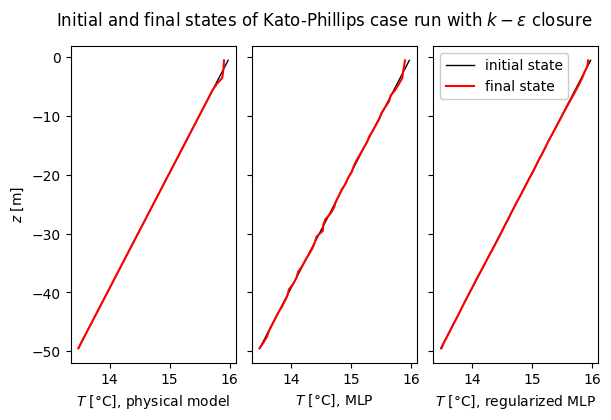

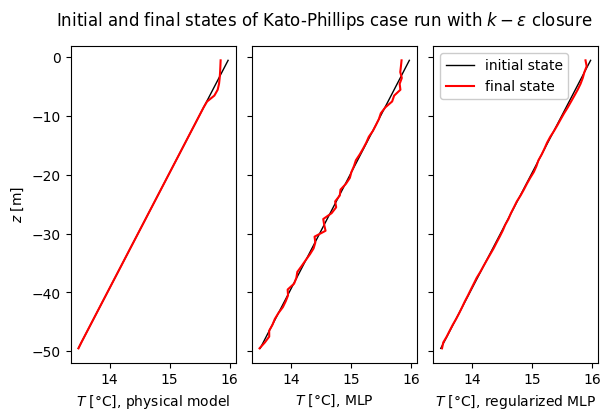

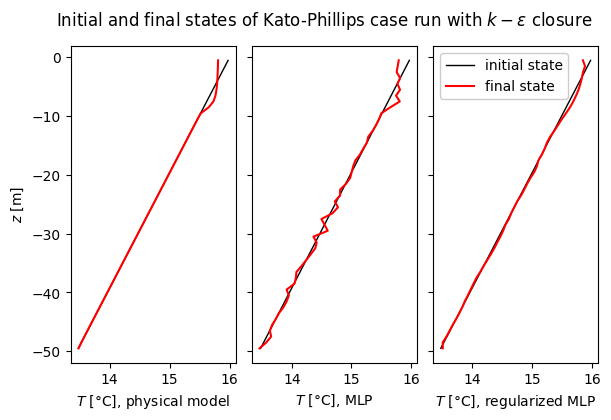

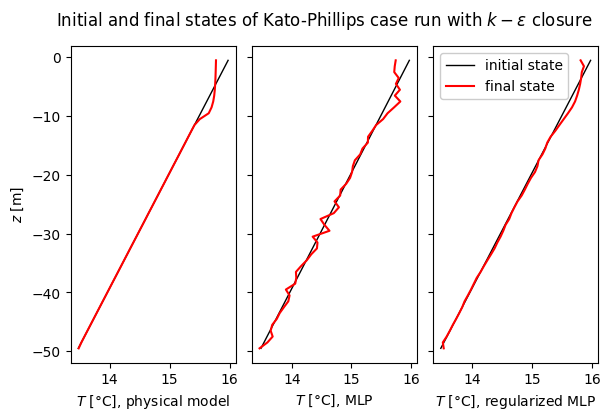

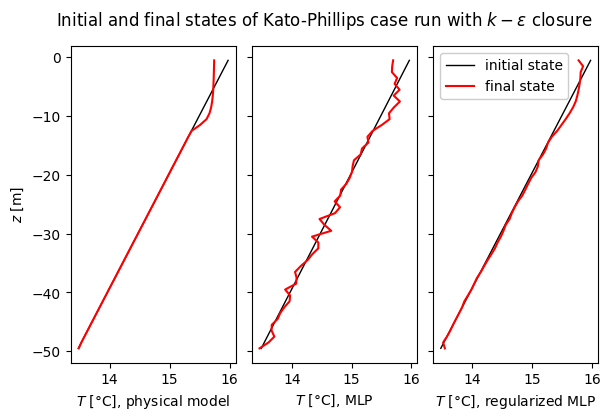

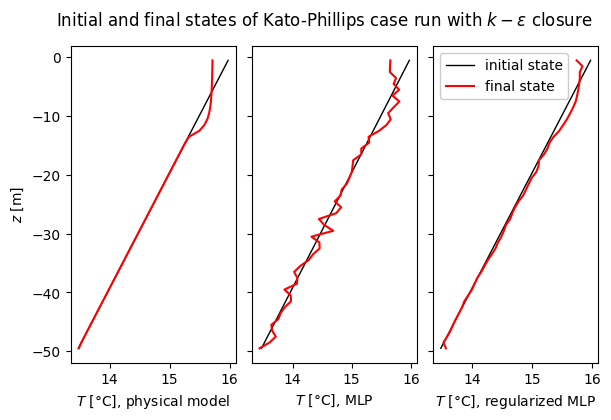

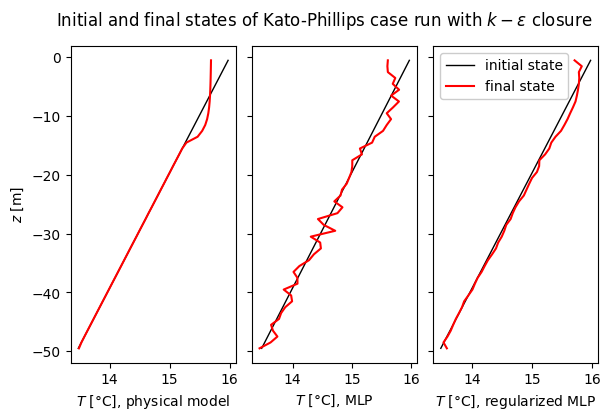

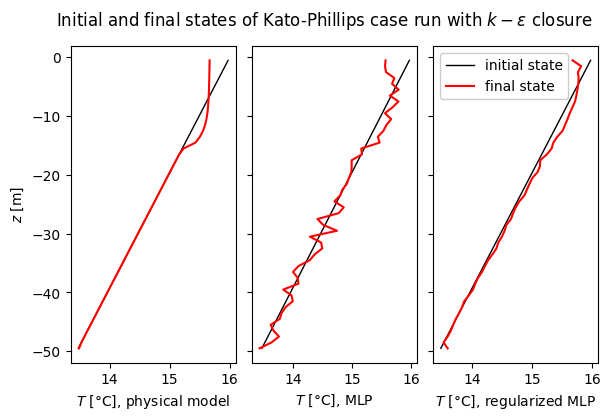

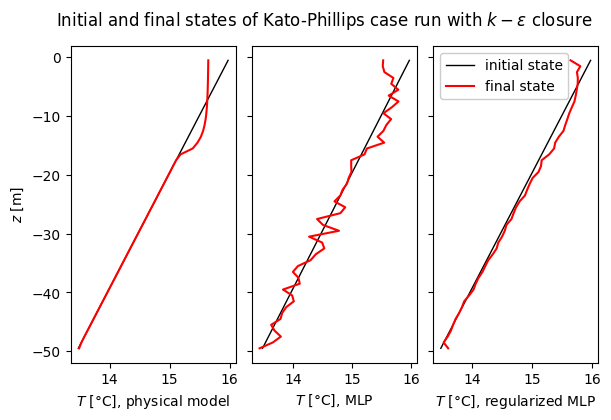

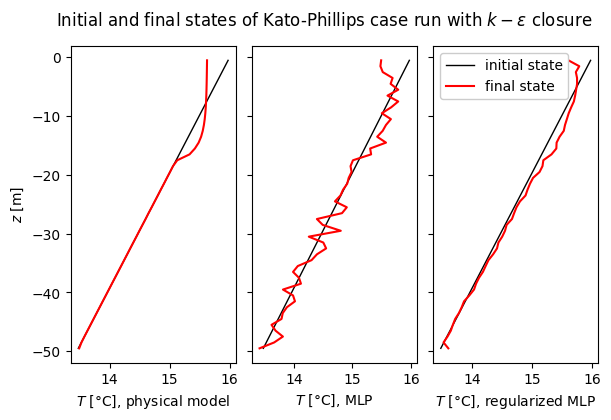

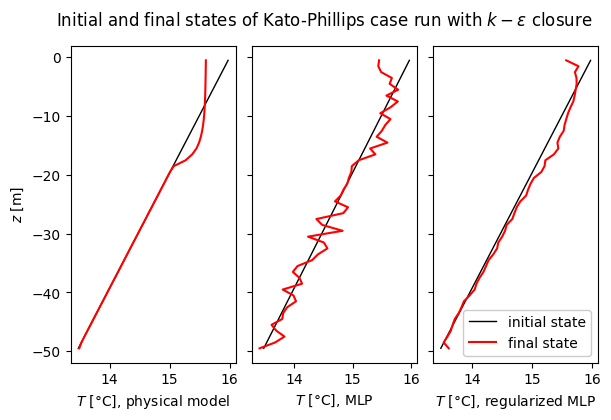

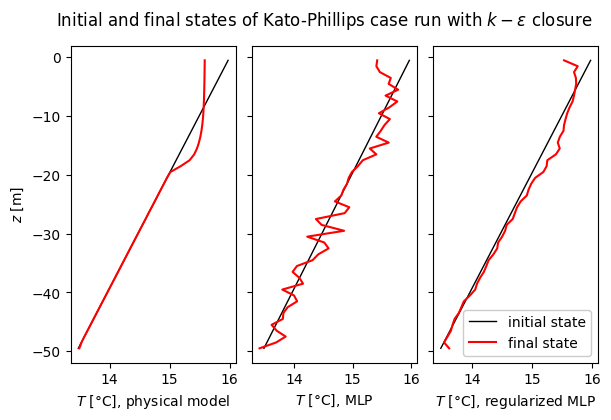

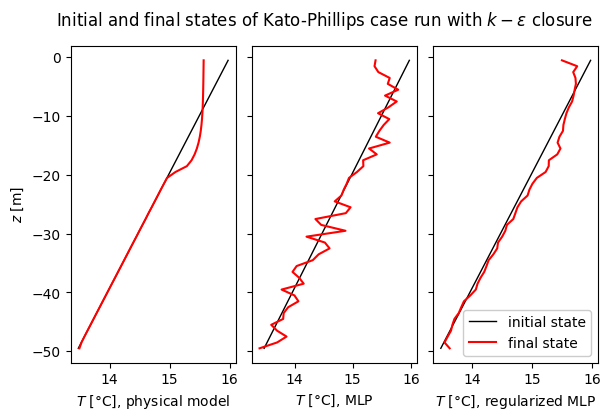

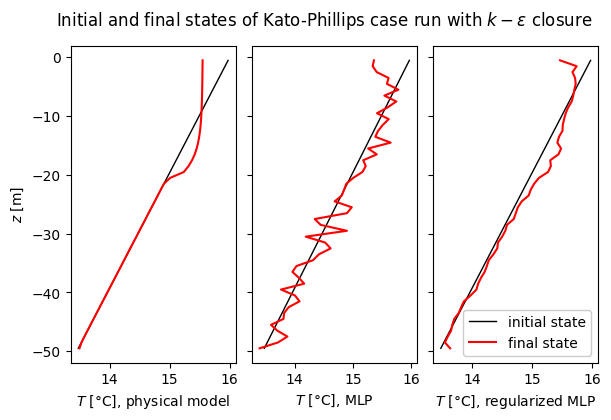

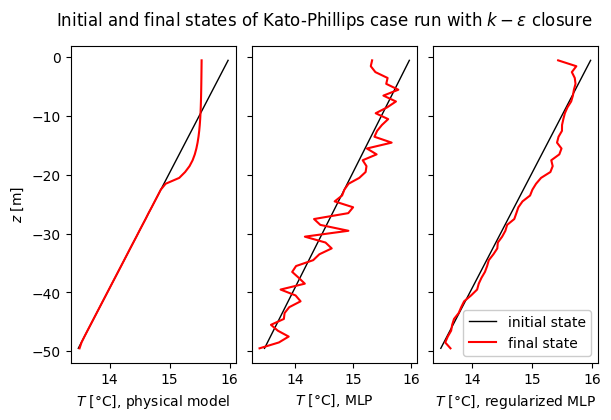

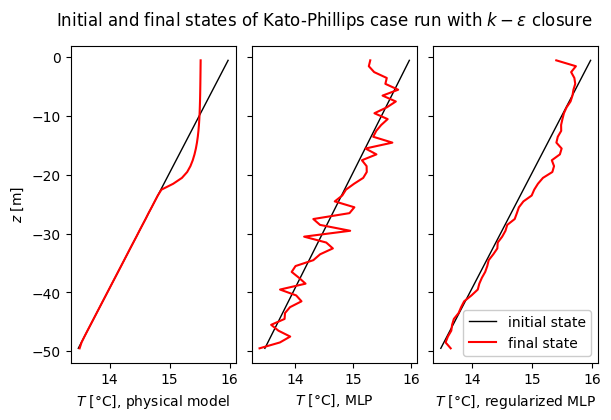

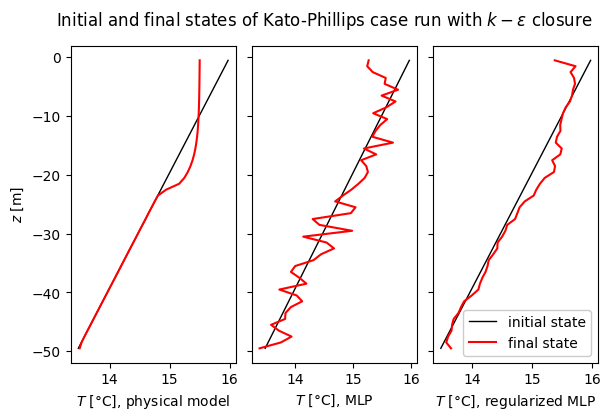

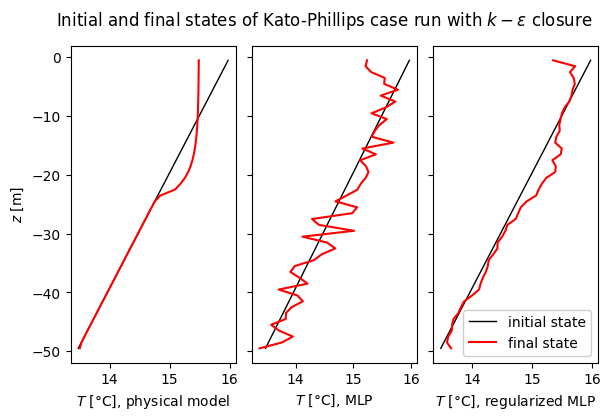

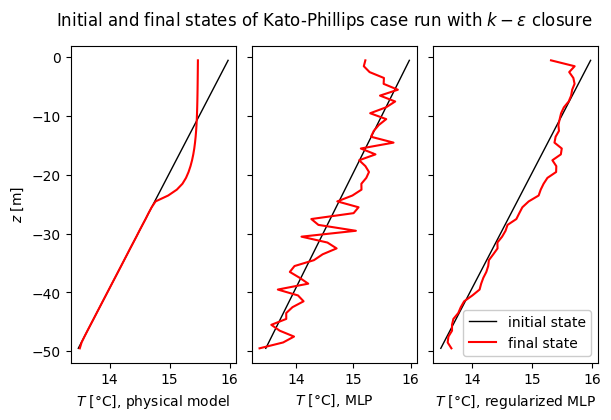

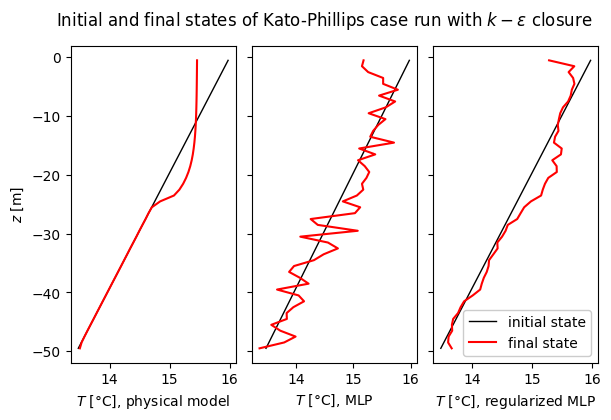

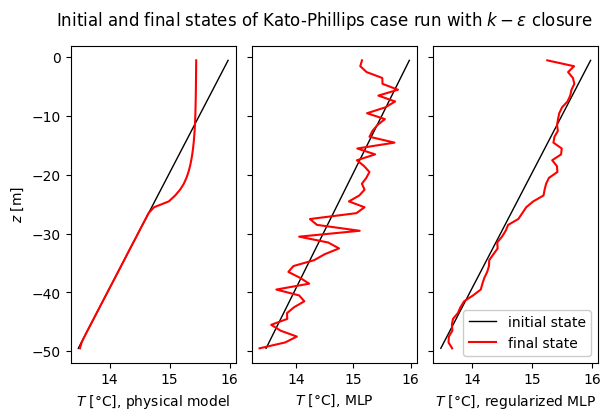

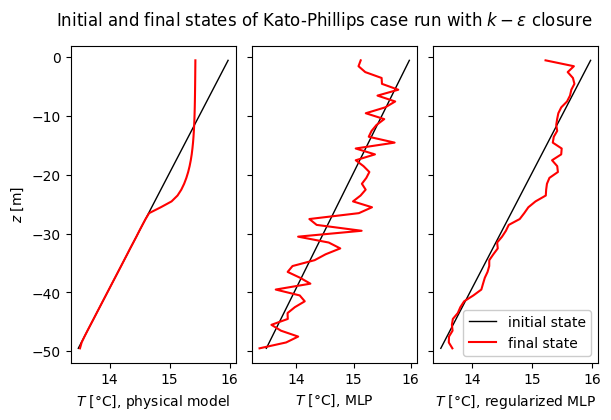

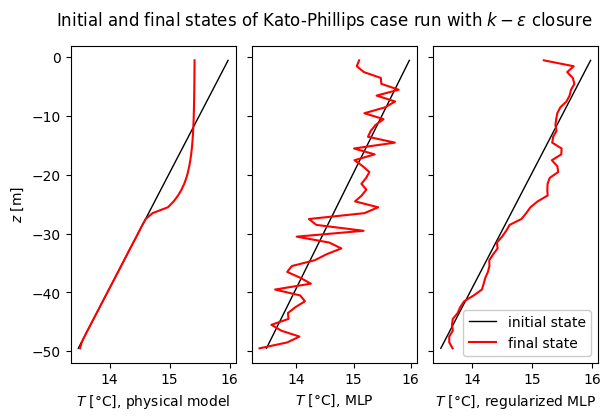

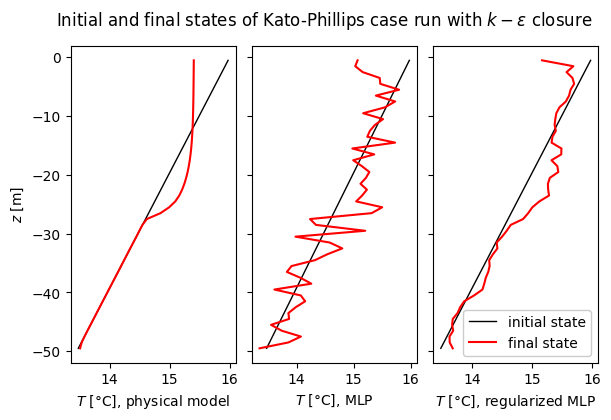

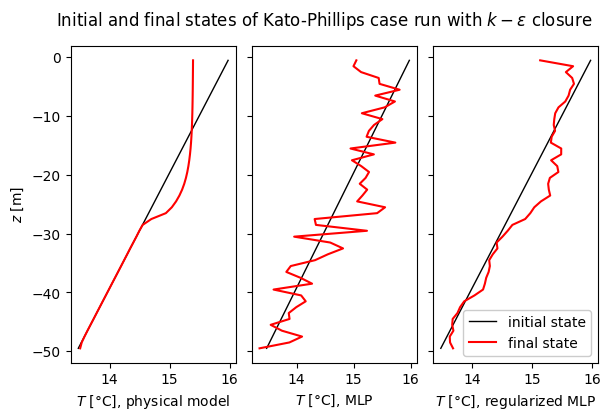

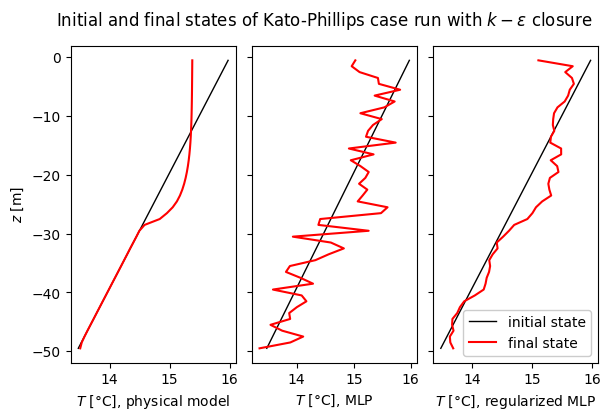

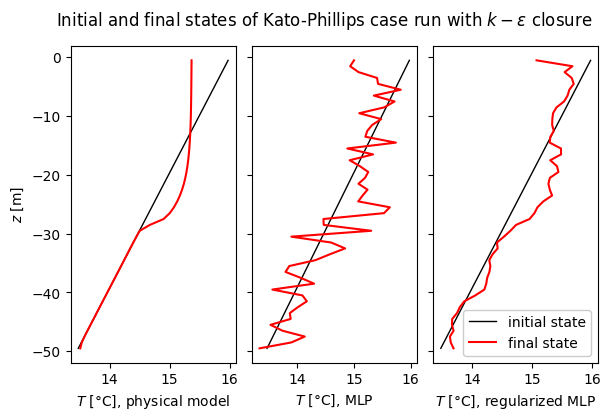

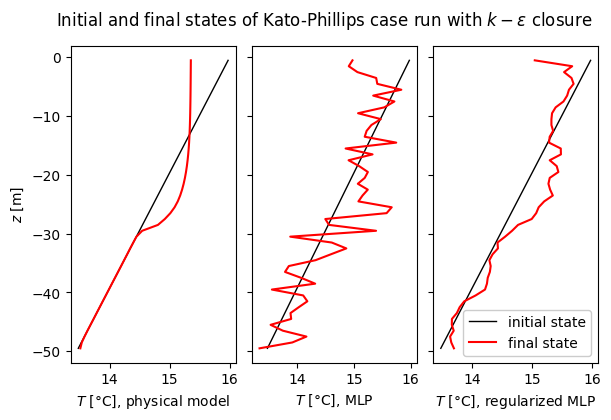

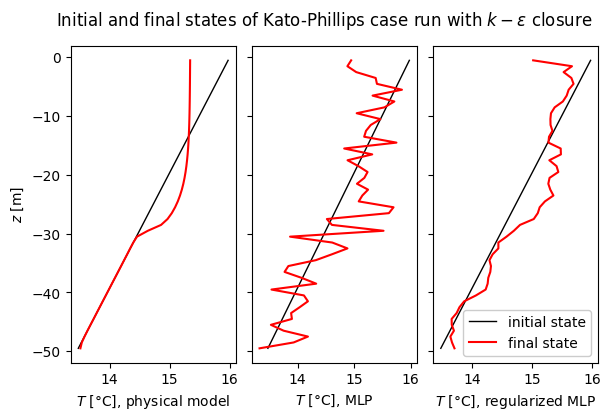

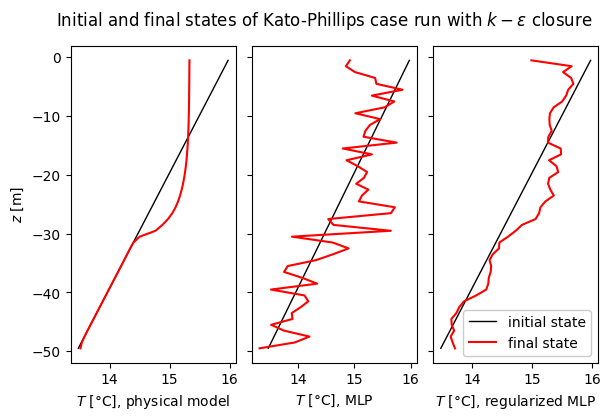

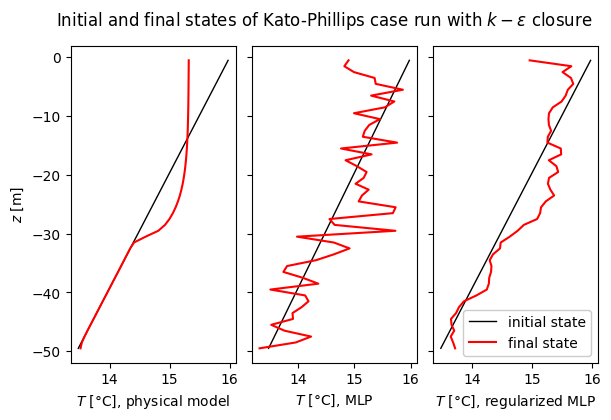

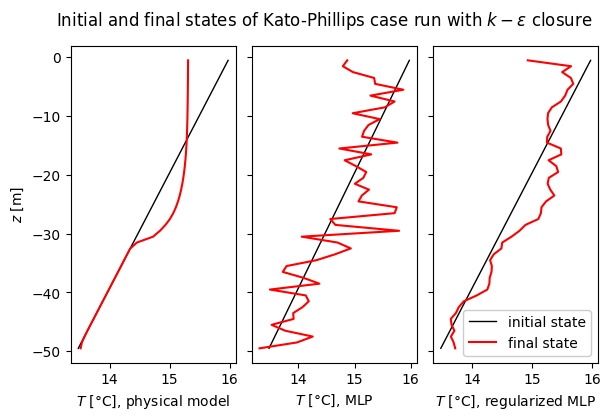

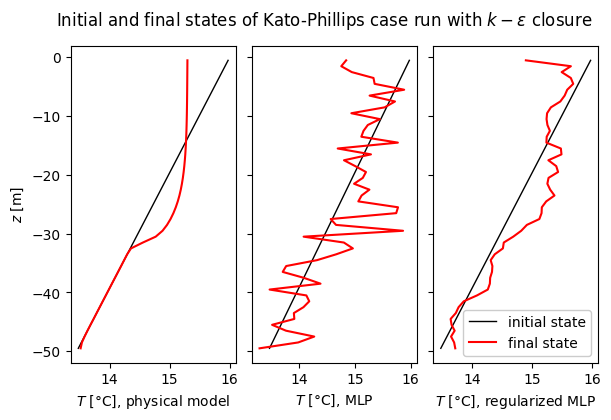

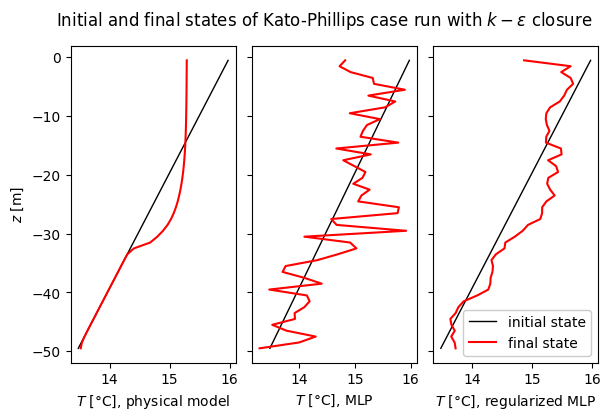

In [62]:
# Track the evolution of the trajectory

sim_index = -1
traj_obs = original_traj[sim_index]
traj_deep = deep_traj[sim_index]

print(f'This trajectory is implied by the following parameters: ')
print(f'strat_t = {round(track_param[sim_index, 0], 3)}, u = {round(track_param[sim_index, 1], 3)}, c1 = {round(track_param[sim_index, 2], 3)}.')

zr = grid.zr

#for time in range(n_time):
for time in range(n_time//10):
    
    sp: subplot_1D_type = plt.subplots(1, 3, sharey=True, figsize=(6, 4))
    fig, [ax_t, ax_u, ax_v] = sp
    fig.tight_layout(rect=[0, 0.0, 1, 0.94])
    fig.subplots_adjust(wspace=0.1)
    ax_t.plot(traj_obs.t[0, :], zr, 'k', linewidth=1)
    ax_t.plot(traj_obs.t[time*10, :], zr, 'r')
    ax_u.plot(traj_deep.t[0, :], zr, 'k', linewidth=1)
    ax_u.plot(traj_deep.t[time*10, :], zr, 'r')
    ax_v.plot(traj_deep_reg.t[0, :], zr, 'k', linewidth=1, label='initial state')
    ax_v.plot(traj_deep_reg.t[time*10, :], zr, 'r', label='final state')

    ax_t.set_xlabel ('$T$ [°C], physical model')
    ax_u.set_xlabel ('$T$ [°C], MLP')
    ax_v.set_xlabel('$T$ [°C], regularized MLP')
    ax_t.set_ylabel(r'$z$ [m]')
    fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
    ax_v.legend(framealpha=1.)

    plt.show()


This trajectory is implied by the following parameters: 
strat_t = 0.143, u = 0.033, c1 = 8.05.


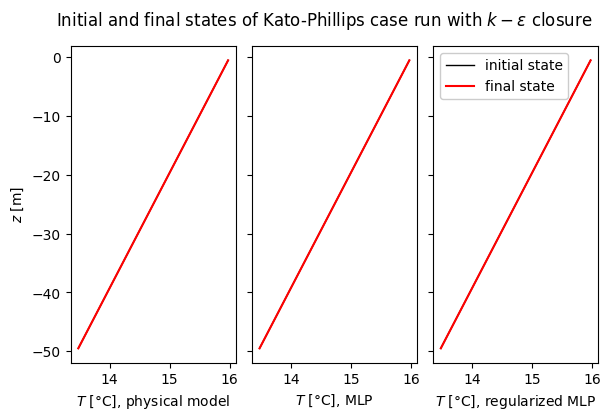

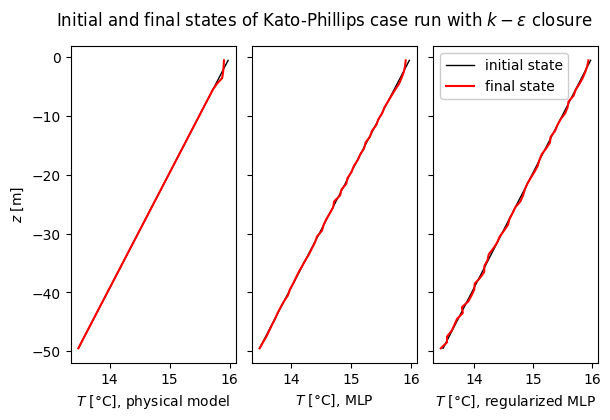

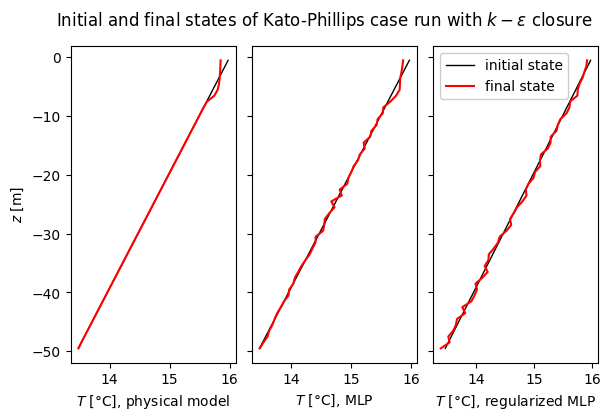

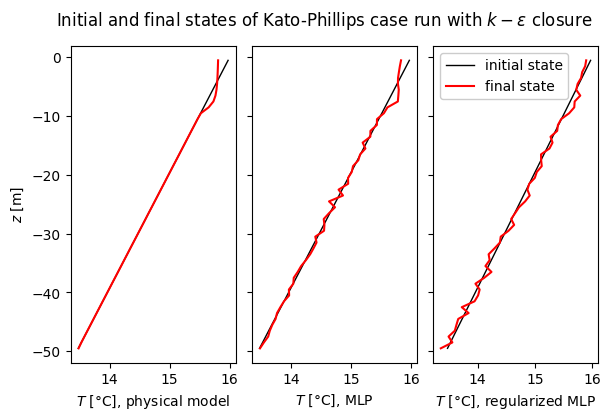

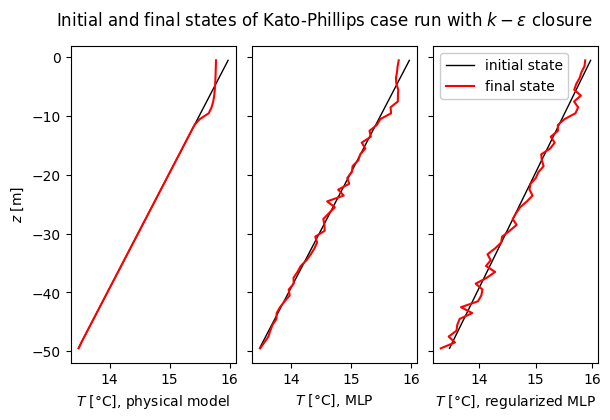

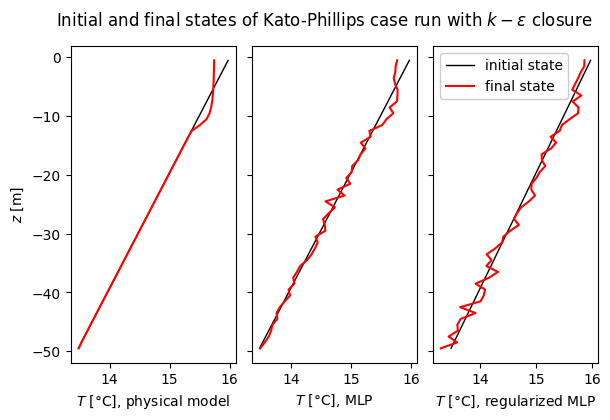

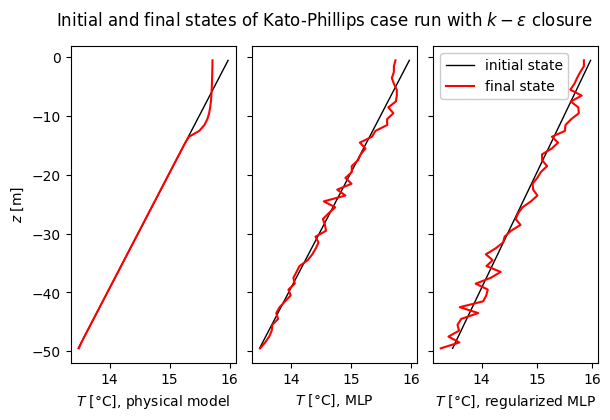

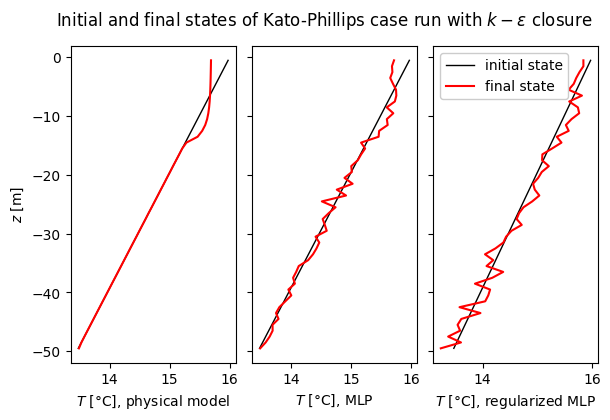

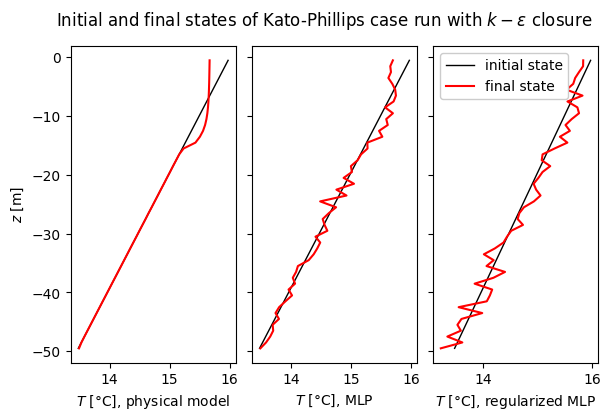

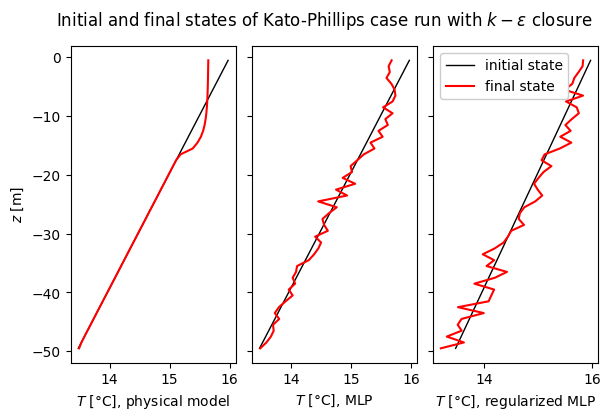

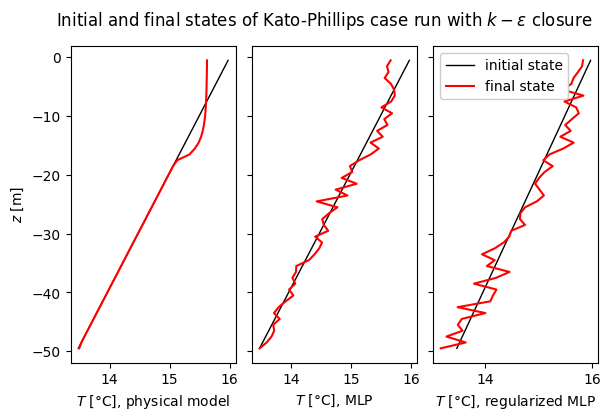

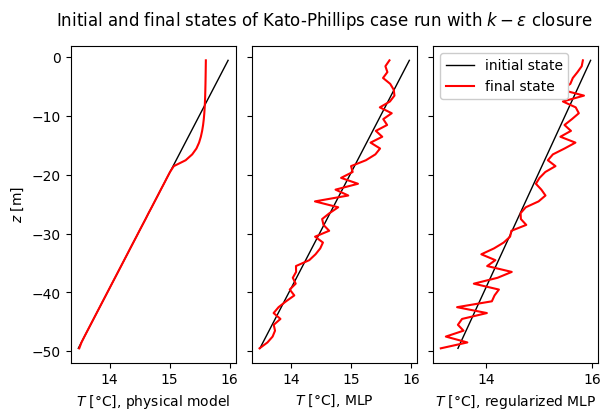

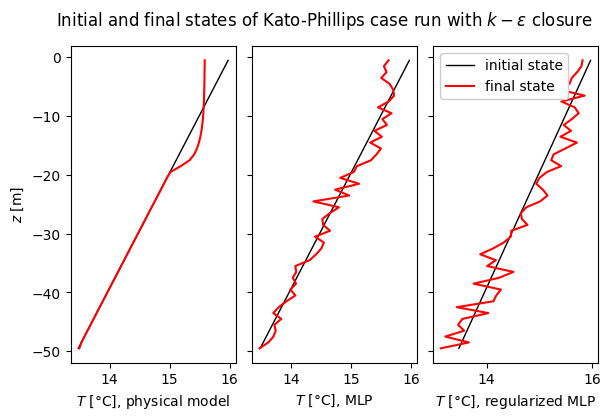

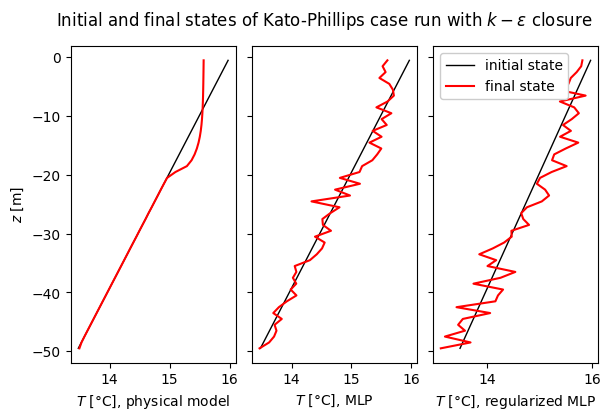

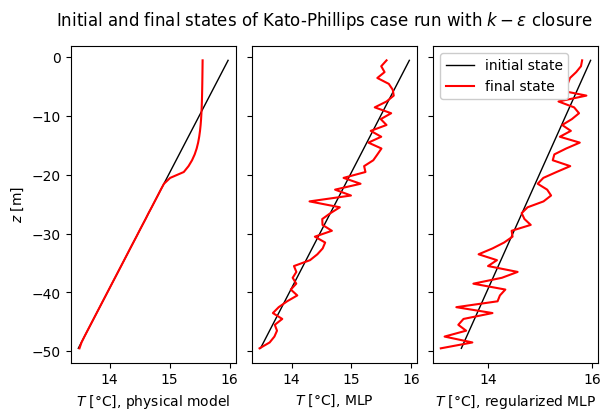

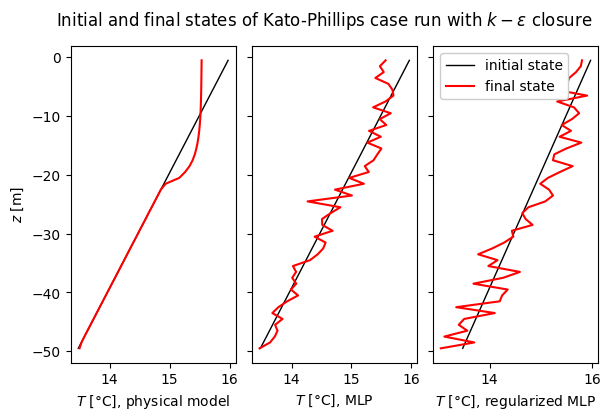

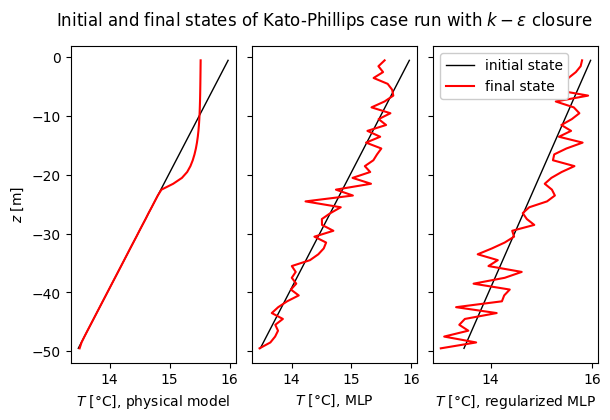

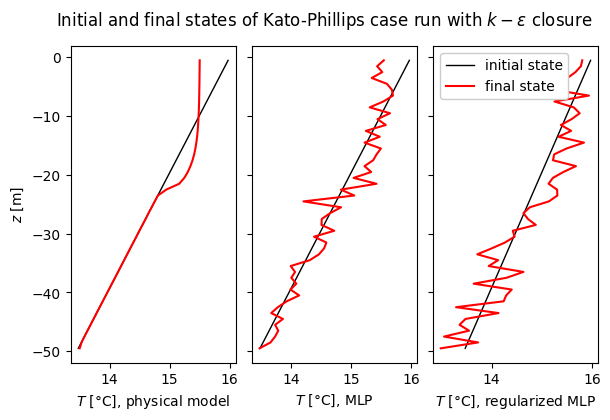

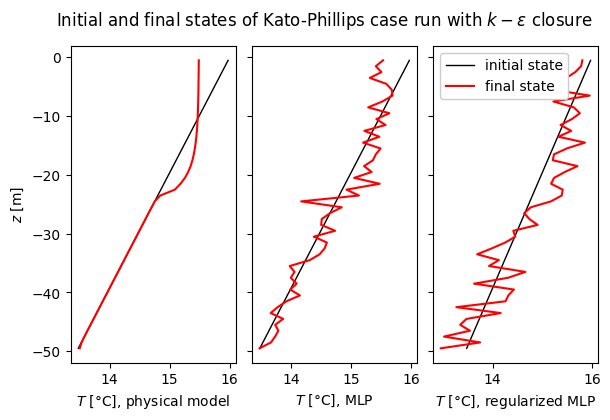

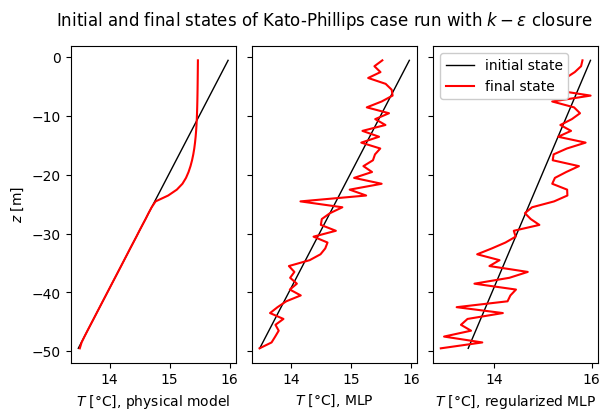

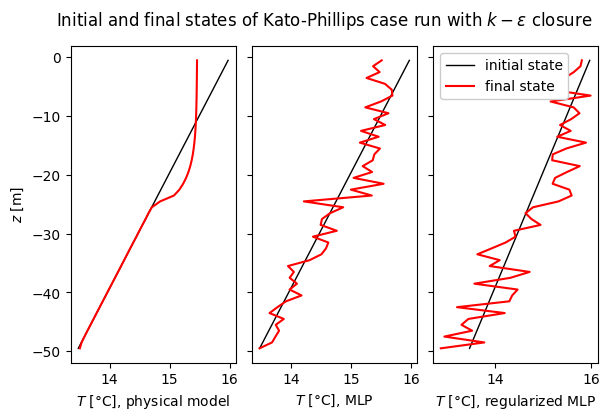

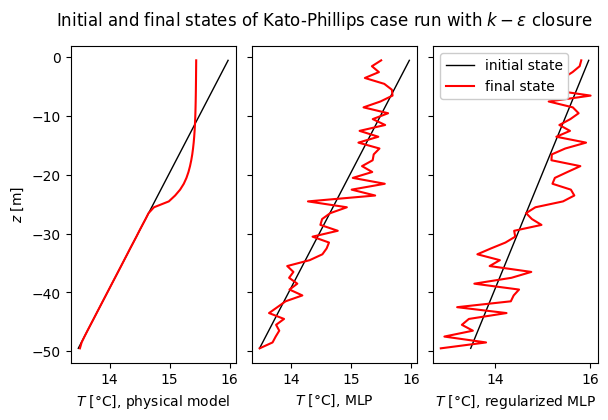

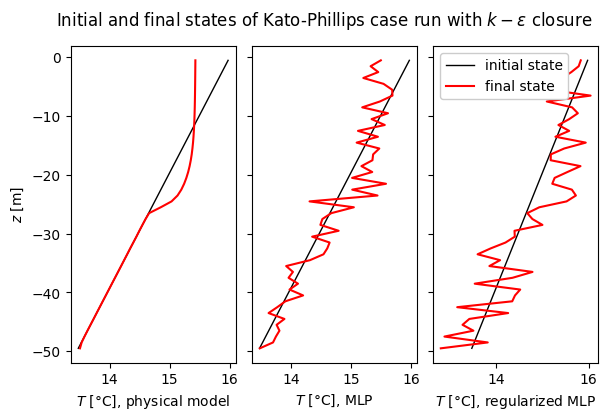

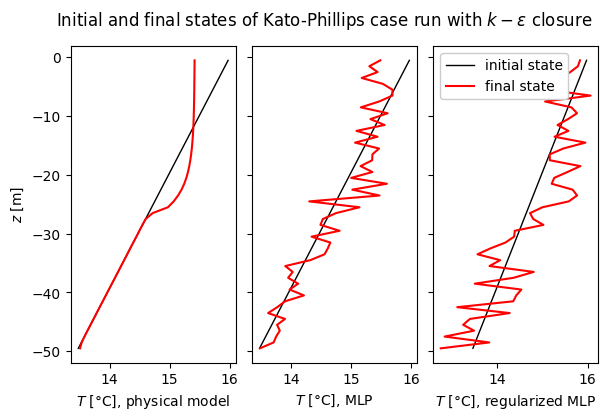

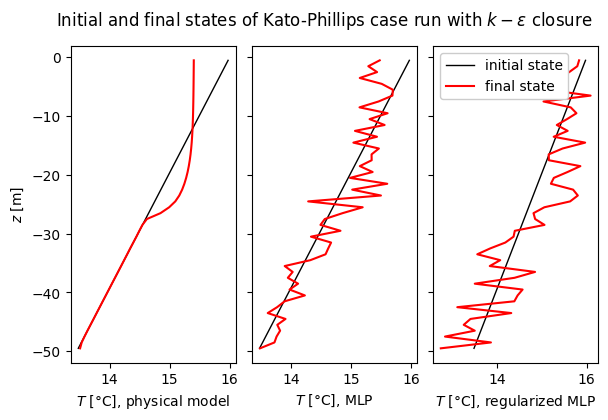

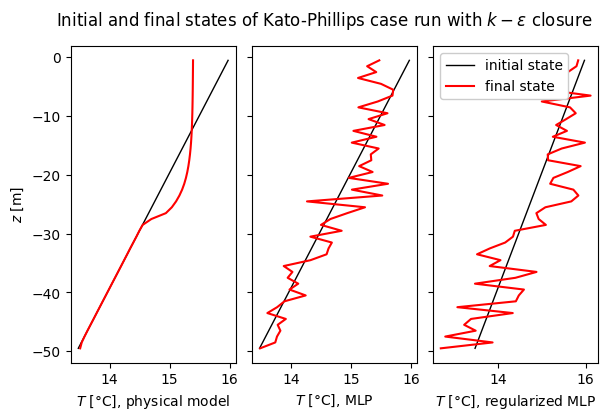

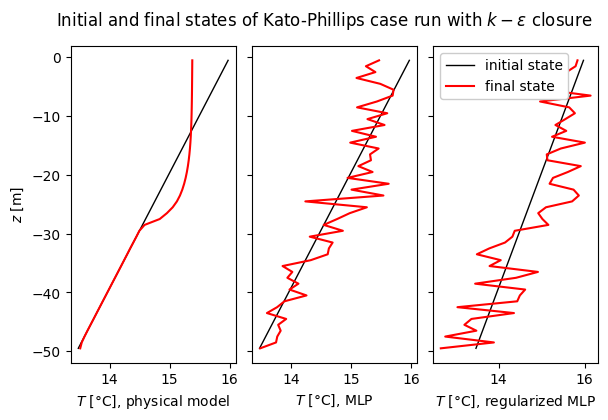

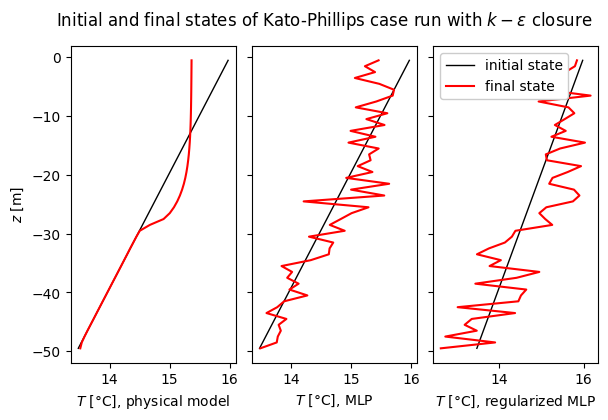

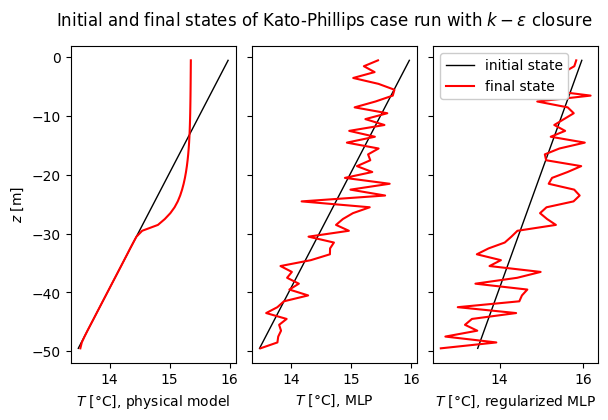

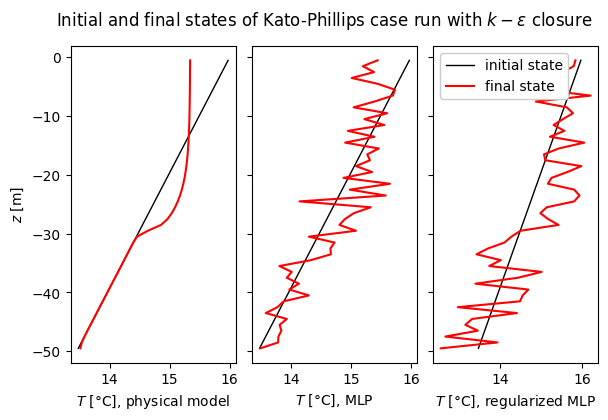

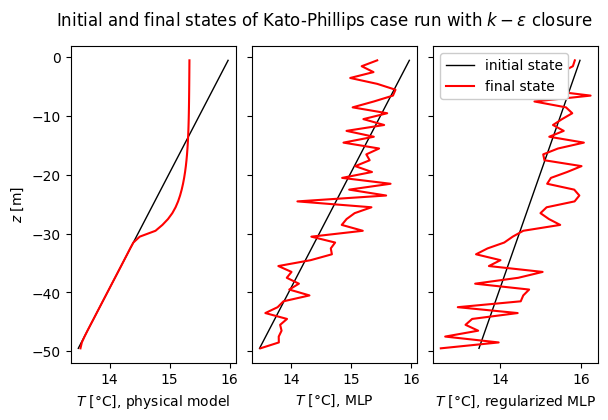

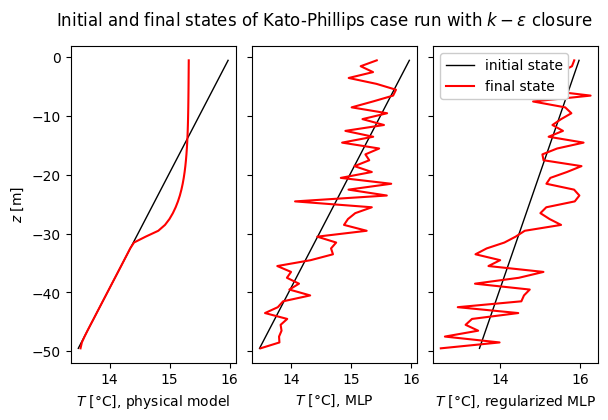

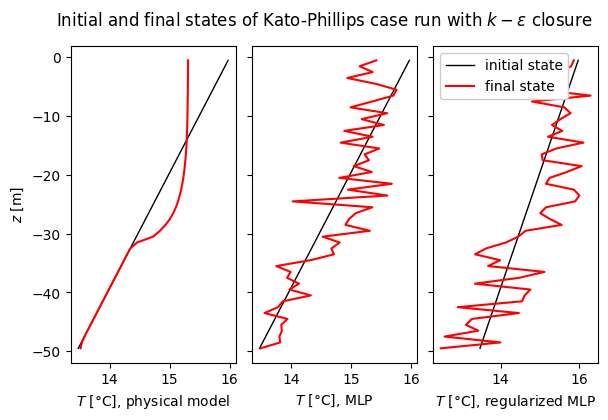

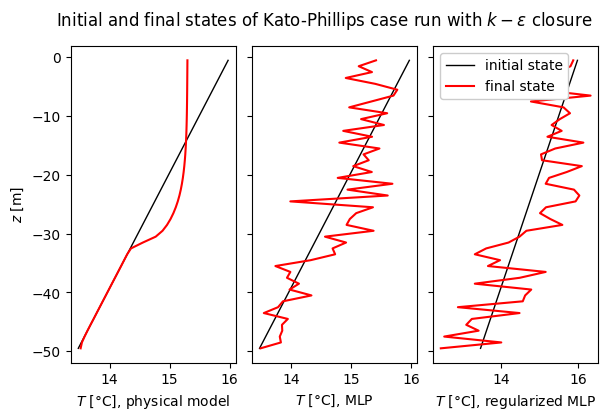

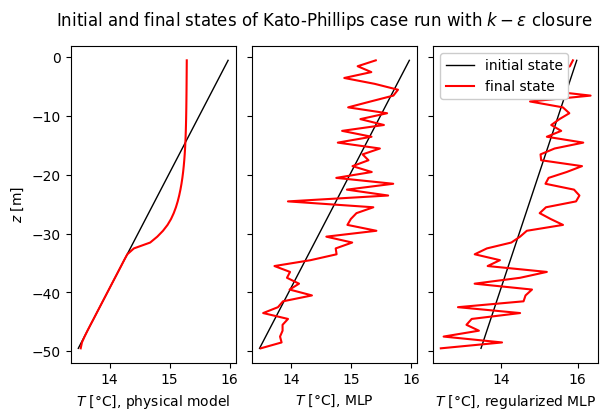

In [136]:
# Track the evolution of the trajectory - with noise augmentation

sim_index = -1
traj_obs = original_traj[sim_index]
traj_deep = deep_traj[sim_index]

print(f'This trajectory is implied by the following parameters: ')
print(f'strat_t = {round(track_param[sim_index, 0], 3)}, u = {round(track_param[sim_index, 1], 3)}, c1 = {round(track_param[sim_index, 2], 3)}.')

zr = grid.zr

#for time in range(n_time):
for time in range(n_time//10):
    
    sp: subplot_1D_type = plt.subplots(1, 3, sharey=True, figsize=(6, 4))
    fig, [ax_t, ax_u, ax_v] = sp
    fig.tight_layout(rect=[0, 0.0, 1, 0.94])
    fig.subplots_adjust(wspace=0.1)
    ax_t.plot(traj_obs.t[0, :], zr, 'k', linewidth=1)
    ax_t.plot(traj_obs.t[time*10, :], zr, 'r')
    ax_u.plot(traj_deep.t[0, :], zr, 'k', linewidth=1)
    ax_u.plot(traj_deep.t[time*10, :], zr, 'r')
    ax_v.plot(traj_deep_reg.t[0, :], zr, 'k', linewidth=1, label='initial state')
    ax_v.plot(traj_deep_reg.t[time*10, :], zr, 'r', label='final state')

    ax_t.set_xlabel ('$T$ [°C], physical model')
    ax_u.set_xlabel ('$T$ [°C], MLP')
    ax_v.set_xlabel('$T$ [°C], regularized MLP')
    ax_t.set_ylabel(r'$z$ [m]')
    fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
    ax_v.legend(framealpha=1.)

    plt.show()